In [2]:
! pip install -q 'lalsuite==6.66' 'bilby==0.6.1' 'gwpy==1.0.1'

     |████████████████████████████████| 28.5 MB 64 kB/s 
     |████████████████████████████████| 1.5 MB 70.1 MB/s 
     |████████████████████████████████| 1.4 MB 49.9 MB/s 
     |████████████████████████████████| 52 kB 966 kB/s 
     |████████████████████████████████| 1.6 MB 53.7 MB/s 
     |████████████████████████████████| 87 kB 6.3 MB/s 
     |████████████████████████████████| 45 kB 3.1 MB/s 
     |████████████████████████████████| 54 kB 2.2 MB/s 
     |████████████████████████████████| 3.2 MB 41.6 MB/s 


In [ ]:
! git clone https://github.com/matteobreschi/bajes.git

In [ ]:
%cd bajes
! ls
! python setup.py install

In [5]:
#importing packages
from gwpy.timeseries import TimeSeries
import h5py
import numpy as np
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import math
from bajes.obs.gw import Series

#import drive so csv file wont just save during runtime
from google.colab import drive 
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [6]:
time_of_event = 1187008882.4

post_trigger_duration =4
duration = 8
analysis_start = time_of_event + post_trigger_duration - duration

# Use gwpy to fetch the open data
H1_analysis_data = TimeSeries.fetch_open_data(
    "H1", analysis_start, analysis_start + duration, sample_rate=4096*4, cache=True)

t = H1_analysis_data.times
strain = H1_analysis_data.value

# set the data properties coherently
seglen = 8           # duration of the segment [s]
srate  = 4096*4        # sampling rate [Hz]
t_gps  = 0 # central value of GPS time
f_max  = 1024*4 
f_min  = 20 

series = Series('time', strain, seglen=seglen, srate=srate, t_gps=t_gps, f_min=f_min, f_max=f_max)


from bajes.obs.gw import Waveform

wave  = Waveform(series.freqs, srate, seglen, 'NRPM') #NRPM for postmergers

/usr/local/lib/python3.7/dist-packages/gwpy/types/series.py:926: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)


In [7]:
#assigning variables to data from GW170817 with source file 
#downloaded from https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW170817/v3/

fn = "/content/drive/MyDrive/Colab_Notebooks/GW170817/GW170817_GWTC-1.hdf5"
data = h5py.File(fn,'r')

#defining samples

posterior_samples = data['IMRPhenomPv2NRT_highSpin_posterior']

#using pandas to set pnames

pnames = posterior_samples.dtype.names

#reading in mass 1 samples

ind = pnames.index('m1_detector_frame_Msun')

m1_samples = np.array([samp[ind] for samp in posterior_samples[()]])

print(m1_samples)

#reading in mass 2 samples

ind = pnames.index('m2_detector_frame_Msun')

m2_samples = np.array([samp[ind] for samp in posterior_samples[()]])

#Defining and printing lambda1 parameter

ind = pnames.index('lambda1')

lambda1_samples = np.array([samp[ind] for samp in posterior_samples[()]])


#defining and printing lambda2 parameter
ind = pnames.index('lambda2')

lambda2_samples = np.array([samp[ind] for samp in posterior_samples[()]])



[1.82241211 1.69103766 1.71265053 ... 1.64822997 1.53093584
 1.86249465]


In [ ]:
!pip install pycbc
import pylab

from pycbc import waveform
from pycbc.types import TimeSeries as PTimeSeries, FrequencySeries

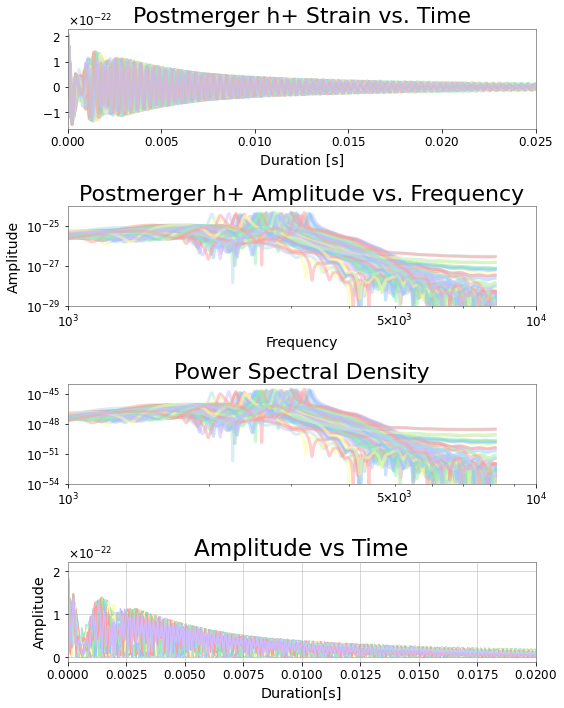

In [12]:
#using NRPM

#GW170817 has array shape ~4000, arr_index is choosing where in the array to start taking data
arr_index = 105

#declaration of variables for easy adjustment
deltaT= 1./srate
#c = "white"
transparency = 0.5
lwidth= 3
iterations= 100

#make 3 subplots so all simulations could be grouped together
#formatting all 3 subplots
plt.style.use('seaborn-pastel')
fig, (f1, f2, f3, f4) = plt.subplots(4, figsize=(8, 10))
#f1.set_facecolor(c)
#f2.set_facecolor(c)
#f3.set_facecolor(c)

#make simulations
for num in range(iterations):
#get values from the GW170817 data
  m1 = m1_samples[arr_index]
  m2= m2_samples[arr_index]
  lambda1= lambda1_samples[arr_index]
  lambda2= lambda2_samples[arr_index]
#NRPM approx is fickle and does not work if lambda values are lower than 350
#experimenting have found that sometimes it would work if a lambda1 = ~200 and lambda2 = >1000
#however, for ease of use, I just set the values for both lambda values to be 350 or up
  while lambda1 <= 350.0 or lambda2 <=350.0:
    arr_index = arr_index + 1
    m1 = m1_samples[arr_index]
    m2= m2_samples[arr_index]
    lambda1= lambda1_samples[arr_index]
    lambda2= lambda2_samples[arr_index]
    
    
  #calculate chirp mass and mass ratio based on values received from previous data
  chirp_mass = (math.pow((m1 * m2), (3/5))) / (math.pow((m1 + m2), (1/5)))
  q = m1 / m2

#parameters for new waveform
  params = {'mchirp'       : chirp_mass,    # chirp mass [solar masses] 
              'q'          : q,      # mass ratio 
              's1x'        : 0.,      # primary spin parameter, x component
              's1y'        : 0.,      # primary spin parameter, y component
              's1z'        : 0.,      # primary spin parameter, z component
              's2x'        : 0.,      # secondary spin parameter, x component
              's2y'        : 0.,      # secondary spin parameter, y component
              's2z'        : 0.,      # secondary spin parameter, z component
              'lambda1'    : lambda1,    # primary tidal parameter 
              'lambda2'    : lambda2,    # secondary tidal parameter
              'distance'   : 100.8114416513031,    # distance [Mpc]   
              'iota'       : np.pi,   # inclination [rad]   
              'ra'         : 0.,     # right ascension [rad]
              'dec'        : 0.,   # declination [rad]
              'psi'        : 0.,      # polarization angle [rad]
              'time_shift' : 0.419,   # time shift from GPS time [s]
              'phi_ref'    : 0.,      # phase shift [rad]
              'f_min'      : 20.,     # minimum frequency [Hz]
              'srate'      : srate,   # sampling rate [Hz]
              'seglen'     : seglen,  # segment duration [s] 
              'tukey'      : 0.1,     # parameter for tukey window
              't_gps'      : t_gps,   # GPS trigger time
              'lmax'       : 0., 
              'eccentricity' : 0.
             }  

  #calculates hp and hc
  hp, hc = wave.compute_hphc(params)
  
  #makes a plot of h+ amplitude vs time
 
  f1.plot(series.times, hp, alpha= transparency, linewidth=3, label= None)

  #makes plot of h+ amplitude vs frequency
  
  #uses the pcybc way to get amp and freq by turning hp to a time series then a frequency series
  hp_ts = PTimeSeries(hp, delta_t=deltaT)
  hp_fs = hp_ts.to_frequencyseries(delta_f=0.125) #HP Frequency Series

  f2.loglog(hp_fs.sample_frequencies, np.abs(hp_fs), 
    lw=lwidth, alpha= transparency, label= None)
  
  #makes power spectral density plot

  f3.loglog(hp_fs.sample_frequencies, 4* np.abs(hp_fs) *  np.abs(hp_fs) * hp_fs.sample_frequencies,  
     lw=lwidth, alpha= transparency, label=None)
  
  #makes amplitude vs time plot

  f4.plot(series.times, np.abs(hp))

  #iterates arr_index for next simulation
  arr_index = arr_index + 1
  
 

#formating our waveform graphs individually
f1.set_title('Postmerger h+ Strain vs. Time', fontsize=22, loc='center')
f1.set_xlabel('Duration [s]', fontsize=14)
#f1.set_ylabel("Amplitude", fontsize=14)
f1.set_xlim(0.00, t_gps+0.025)
f1.grid(False)

f2.set_title('Postmerger h+ Amplitude vs. Frequency', fontsize=22)
f2.set_ylabel("Amplitude", fontsize=14)
f2.set_xlabel("Frequency", fontsize=14)
f2.set_xlim(xmin=1000, xmax=10000)
f2.set_ylim(ymin=10**-29, ymax=10**-24)
f2.grid(False)


f3.set_title('Power Spectral Density', fontsize=22)
f3.set_xlim(xmin=10**3, xmax=10**4)
f3.set_ylim(ymin=10**-54, ymax=10**-44)
f3.grid(False)

f4.set_title("Amplitude vs Time", fontsize=23 )
f4.set_xlabel("Duration[s]")
f4.set_ylabel("Amplitude")
f4.set_xlim(xmin=.0, xmax=0.02)

plt.tight_layout()
fig.savefig('/content/drive/MyDrive/Colab_Notebooks/GW170817/000d1.png')


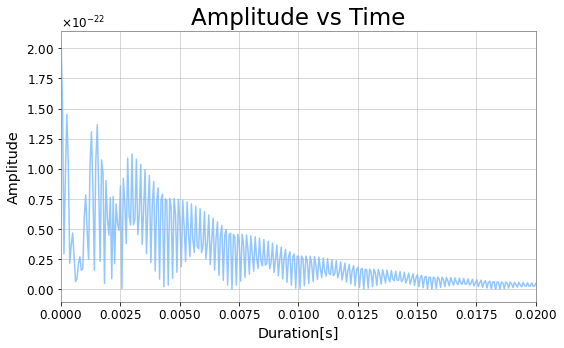

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(series.times, np.abs(hp))
plt.title("Amplitude vs Time", fontsize=23 )
plt.xlabel("Duration[s]")
plt.ylabel("Amplitude")
plt.xlim(.0, 0.02)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/GW170817/amp.png')